# Проект: Определение стоимости автомобилей

[yandex_practicum](https://practicum.yandex.ru/trainer/data-scientist/lesson/2372bd1e-1ce6-4b9c-b73e-d1ce7eb59441/)

Описание проекта:

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать <font color='red'>рыночную стоимость своего автомобиля. </font>

Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

## Описание данных

Признаки

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач

- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

## 1.  Подготовка данных


### 1.1 Загружаем библиотеки и читаем данные

In [1]:
# библиотеки для работы с данными
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math

# библиотека для оценки корреляции
from phik import phik_matrix

# библиотека для оценки важности признаков Шепли (SHAP)
import shap

# бибилотеки для подготовки данных
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler,
                                   PolynomialFeatures, 
                                   OneHotEncoder,
                                   OrdinalEncoder, 
                                   LabelEncoder)

from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE


# библиотеки для пайплайнов
# класс ColumnTransformer помогает работать с данными разного типа в одном наборе
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# класс для работы с пропусками
from sklearn.impute import SimpleImputer

# библиотеки для линейной регрессии
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error ,mean_absolute_error, r2_score, make_scorer


# библиотеки для логистической регрессии
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

# библиотека для метода опорных векторов
from sklearn.svm import SVC

# библиотека решающих деревьев
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor


# бибилиотека для графика ROC-кривой и расчёта ROC-AUC
from sklearn.metrics import roc_auc_score, RocCurveDisplay


# библиотека для модели классификации kNN 
from sklearn.neighbors import KNeighborsClassifier

# добавим библиотеку для построения scatter диаграмм рассеяния с тренд-линиями
import plotly.express as px 
import plotly.graph_objects as go



In [2]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except FileNotFoundError:
    data = pd.read_csv('/Users/tony_builder/Documents/GitHub/studying/yandex_practicum/12_numeric_methods/data/autos.csv')

data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.groupby(['Brand', 'Model', 'Gearbox']).agg({'FuelType': list}).reset_index()

,Brand,Model,Gearbox,FuelType
0,alfa_romeo,145,manual,"[petrol, petrol, petrol, petrol, petrol, petro..."
1,alfa_romeo,147,auto,"[petrol, petrol, petrol, petrol, petrol, petro..."
2,alfa_romeo,147,manual,"[gasoline, petrol, petrol, petrol, petrol, pet..."
3,alfa_romeo,156,auto,"[petrol, petrol, petrol, petrol, petrol, petro..."
4,alfa_romeo,156,manual,"[petrol, petrol, petrol, petrol, petrol, petro..."
...,...,...,...,...
567,volvo,v60,manual,"[gasoline, petrol, gasoline, gasoline, gasolin..."
568,volvo,v70,auto,"[petrol, gasoline, gasoline, petrol, gasoline,..."
569,volvo,v70,manual,"[petrol, petrol, petrol, petrol, petrol, petro..."
570,volvo,xc_reihe,auto,"[gasoline, petrol, petrol, gasoline, petrol, g..."


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### 1.2 Ищем пустые значения

In [5]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Итак, пропущенные значения в столбцах:
- тип кузова
- тип коробки передач
- модель
- тип топлива
- столбец с информацией о ремонте машины (да/нет)

Объем пропущенных данных довольно большой - от 5 до 20% 


Для начала приведем типы данных к верному:
- DateCrawled, DateCreated, LastSeen - к datetime 

Остальные типы данных верные

In [6]:

data = data.astype({'DateCrawled':'datetime64','DateCreated':'datetime64','LastSeen':'datetime64',},errors='ignore')
data[['DateCrawled', 'DateCreated', 'LastSeen']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   DateCrawled  354369 non-null  datetime64[ns]
 1   DateCreated  354369 non-null  datetime64[ns]
 2   LastSeen     354369 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 8.1 MB


Теперь посмотрим на дубликаты

In [7]:
data.duplicated().sum()

4

Удалим дубликаты

In [8]:
data.drop_duplicates(inplace=True)

#### 1.2.1 Проведем исследовательский анализ данных по признакам с пропущенными значениями

Сначала создадим нужные функции:

- вытягивания имени из переменной (для корректного наименования графиков)
- построения гистограммы и boxplot для количественных признаков
- построения столбчатых диаграмм для категориальных признаков

- сборная функция построения всей аналитики для любого датасета

In [9]:
# функция получения имени переменной

def get_var_name(var, caller_locals):
    import inspect
    for name, value in caller_locals.items():
        if value is var:
            return name
    return None

In [10]:
# функция для построения гистограммы и boxplot для любого столбца любого датафрейма

def plot_hist_boxplot(some_df, col, col_name, dataset_name):

    df_for_plot= some_df[col]

    # Рассчитываем квартили
    q25, q75 = df_for_plot.quantile(0.25), df_for_plot.quantile(0.75)
    min_val = int(q25- 1.5*(q75-q25))
    max_val= int(q75 +  1.5*(q75-q25))

    # Создаем новый график
    plt.figure(figsize=(10, 10))

    # Строим гистограмму
    plt.subplot(2, 1, 1)  # 2 строки, 1 столбец, график 1
    plt.hist(df_for_plot, bins=20, range=(min_val, max_val))
    plt.title(f'Гистограмма для признака {col_name} для датасета {dataset_name}')
    plt.xlabel(f'значения признака {col_name}')
    plt.ylabel(f'Частота')


    # Помечаем квартили на гистограмме
    plt.axvline(q25, color='r', linestyle='--', label='25th percentile')
    plt.axvline(q75, color='g', linestyle='--', label='75th percentile')
    plt.legend()

    # Строим график boxplot
    plt.subplot(2, 1, 2)  # 2 строки, 1 столбец, график 2
    plt.boxplot(df_for_plot, vert=False)
    plt.title(f'Boxplot признака {col_name} для датасета {dataset_name}')
    plt.xlabel(f'Значение признака {col_name}')

    # Помечаем квартили на boxplot
    plt.axvline(q25, color='r', linestyle='--', label='25th percentile')
    plt.axvline(q75, color='g', linestyle='--', label='75th percentile')
    plt.legend()


    # Показываем графики
    plt.tight_layout()  # Для автоматического выравнивания графиков
    plt.show()


        

In [11]:
# функция построения столбчатой диаграммы

def barplot_df(dataset, col, col_name, dataset_name, dropna=False):
    dataset[col].value_counts(dropna=dropna).plot(kind='bar', legend=True, figsize=(10,5))
    plt.title(f'Диаграмма частоты признака {col_name} для датасета {dataset_name}')
    plt.xlabel(f'значение признака {col_name}')
    plt.ylabel(f'Частота признака {col_name}')
    plt.show()

    

In [12]:
# функция получения аналитических данных для любой таблицы

def analysis_df(some_df: pd.DataFrame, dropna=False):
    # блок вытягивания имени
    import inspect
    caller_locals = inspect.currentframe().f_back.f_locals

    dataset_name = get_var_name(some_df, caller_locals)
    

    print(f'Статистический анализ таблицы {dataset_name}')  # печатаем имя таблицы (из переменной)
    display(some_df.describe().T)

    # блок построения гистограмм и диаграмм

    cat_col_list = some_df.select_dtypes(exclude='number').columns.tolist()
    num_col_list = some_df.select_dtypes(include='number').columns.tolist()
    
    #dict_names = {v: k for k,v in col_name_dict.items()}

    for col in num_col_list:
        plot_hist_boxplot(some_df=some_df, col_name=col, col=col, dataset_name=dataset_name)

    for col in cat_col_list:   # для категориальных столбцов
        try:
            barplot_df(dataset=some_df, col_name=col, col=col, dataset_name=dataset_name, dropna=dropna)
        except KeyError:
            continue

Построим распределения по каждому из признаков с пустыми значениями

Статистический анализ таблицы None


,count,unique,top,freq
VehicleType,316875,8,sedan,91457
Gearbox,334532,2,manual,268249
Model,334660,250,golf,29232
Repaired,283211,2,no,247158
FuelType,321470,7,petrol,216349


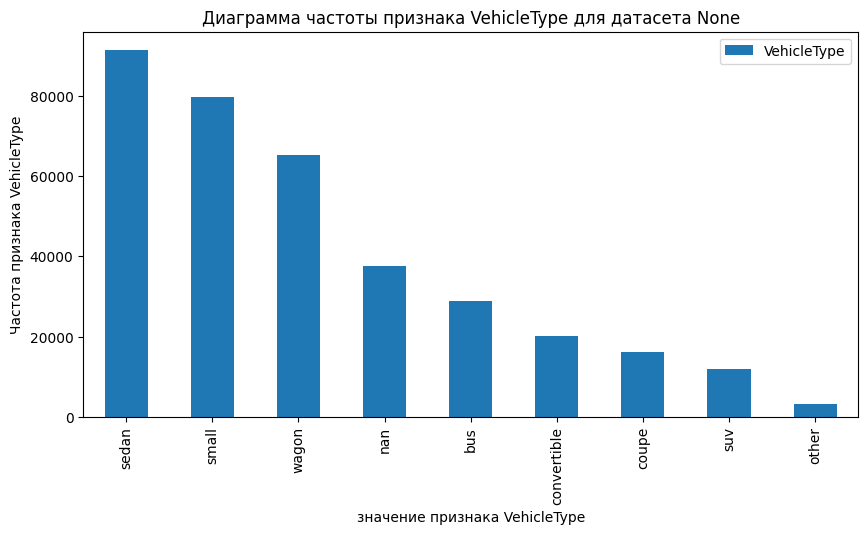

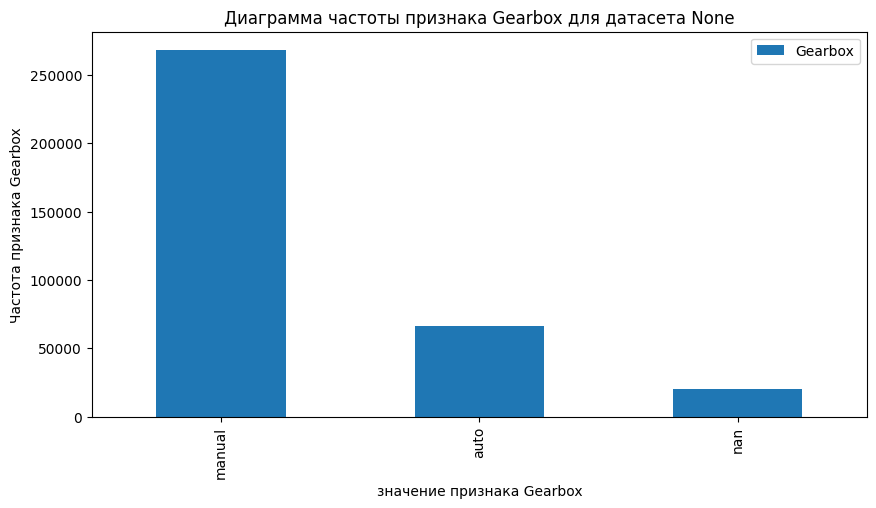

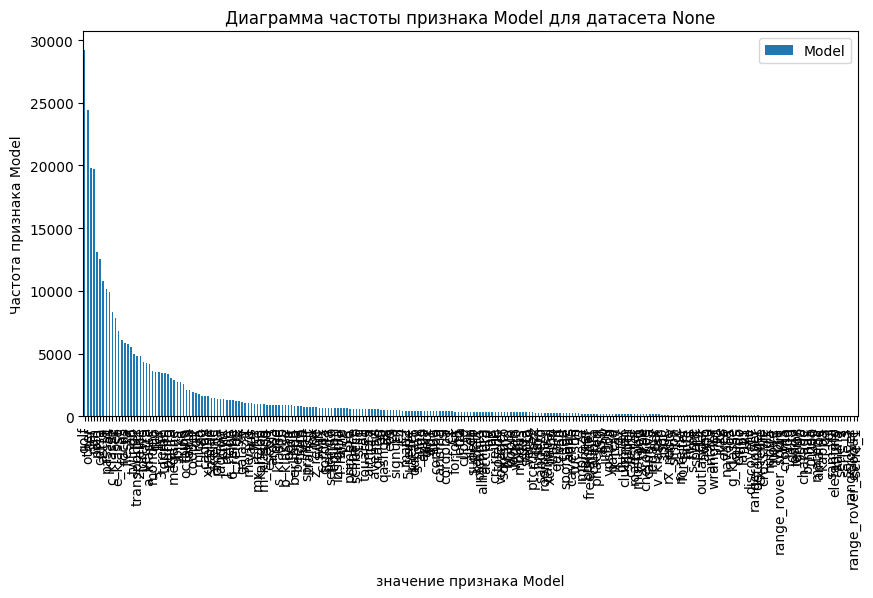

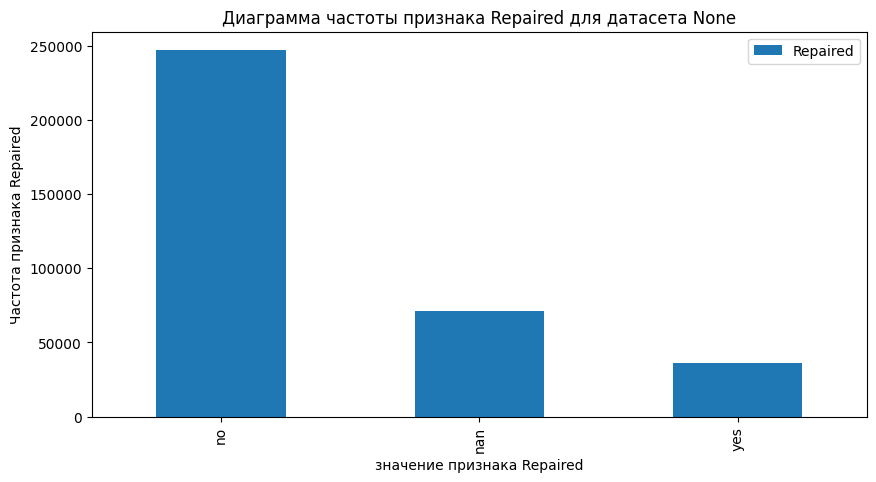

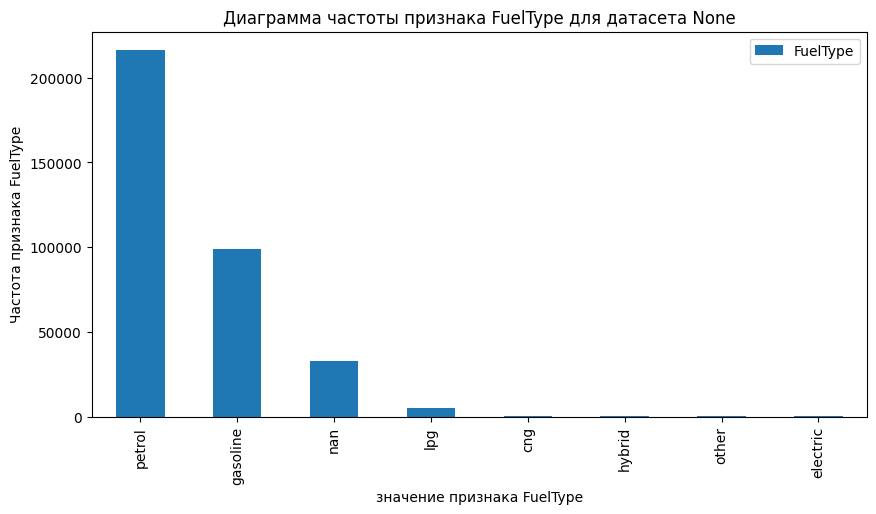

In [13]:
analysis_df(data[['VehicleType', 'Gearbox', 'Model', 'Repaired', 'FuelType']])

Начнем c показателя Тип топлива

1) Судя по информации из открытых источников, Petrol и Gasoline - это один и тот же вид топлива: иначе говоря бензин. Их можно заменить на единое значение - пусть это будет Petrol

2) lpg and cng - два вида газа, которые существенно отличаются. Поэтому их оставим раздельными

3) в целом, колоссальным значением обладают именно бензиновые двигатели по сравнению со всеми остальными(это и понятно)
Заполним пустые значения типа топлива по бренду и модели - чтобы исключить вероятность попадания на электричесмкие или гибридные автомобили

In [14]:
data.loc[data['FuelType'] == 'gasoline', 'FuelType'] = 'petrol'

In [15]:
# Группируем данные по столбцам "Марка" и "Модель", используем режим для нахождения самого частого значения
from statistics import mode

fill_values = data.groupby(['Brand', 'Model'])['FuelType'].transform(lambda x: mode(x.dropna()))

data_1 = data.copy()

data_1['FuelType'] = data_1['FuelType'].fillna(fill_values)

In [16]:
fill_values.unique()

array(['petrol', nan], dtype=object)

Статистический анализ таблицы None


,count,unique,top,freq
FuelType,347202,6,petrol,340800


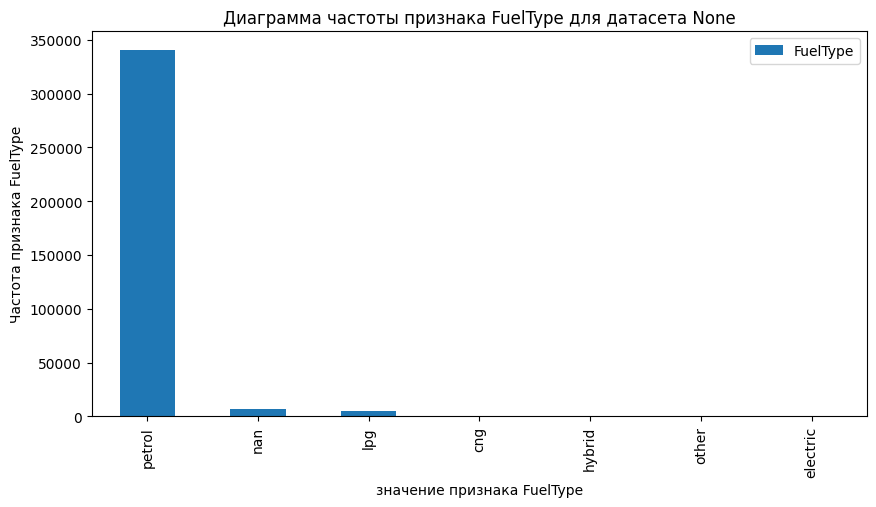

In [17]:
analysis_df(data_1[['FuelType']], dropna=False)

In [18]:
data.FuelType.value_counts(dropna=False)

petrol      315068
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [19]:
data_1.FuelType.value_counts(dropna=False)

petrol      340800
NaN           7163
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

Собственно, никаких значимых изменений нет - все равно все заполняется модой по бензину.
Не вижу причин оставлять оставшиеся 7000 пустых значений - заполним их тоже бензиновыми двигателями

In [20]:
data.FuelType.fillna('petrol', inplace=True)

In [21]:
data.FuelType.isna().sum()

0

Теперь заполним пустоты в информации о ремонте

Наилучшим мне кажется заполнение по пробегу - чем он больше, тем выше вероятность, что машину ремонтировали

In [22]:
fill_values = data.groupby('Kilometer')['Repaired'].transform(lambda x: mode(x.dropna()))

data_1 = data.copy()

data_1['Repaired'] = data_1['Repaired'].fillna(fill_values)

In [23]:
# проверим как отбирается мода для значений по году выпуска
for i in range(8):

    print(mode(data.groupby('Kilometer').agg({'Repaired': lambda x: x.dropna()}).reset_index().Repaired[i]))

no
no
no
no
no
no
no
no


In [24]:
data.Repaired.value_counts(dropna=False)

no     247158
NaN     71154
yes     36053
Name: Repaired, dtype: int64

In [25]:
data_1.Repaired.value_counts(dropna=False)

no     318312
yes     36053
Name: Repaired, dtype: int64

Подавляющая масса машин скорее без ремонта, чем с ремонтом - поэтому заполним все пустые значения 'no'

In [26]:
data.Repaired.fillna('no', inplace= True)

Работаем с признаком Коробка передач: какая именно пропущена - не угадаешь. заполним самым часто встречающимся значением - ручная

In [27]:
data.Gearbox.fillna('manual', inplace=True)

И наконец признак "Модель". Заполнять буду как наиболее часто встречающуюся в Бренде(марке) автомобиля + добавлю мощность в лошадиных силах

In [28]:
temp_df = data.groupby(['Brand', 'Power']).agg({'Model' : lambda x: x.dropna()}).reset_index().rename(columns={'Model': 'list_of_models'})
temp_df


,Brand,Power,list_of_models
0,alfa_romeo,0,"[147, other, 156, 145, 156, 156, spider, 145, ..."
1,alfa_romeo,50,other
2,alfa_romeo,63,other
3,alfa_romeo,65,"[other, other]"
4,alfa_romeo,66,145
...,...,...,...
5427,volvo,300,"[v70, v70]"
5428,volvo,315,"[xc_reihe, xc_reihe, xc_reihe, xc_reihe, other]"
5429,volvo,1056,v40
5430,volvo,1162,v40


Создаю функцию для получения наиболее часто встречающегося значения, но с оговоркой, что могут быть пустые массивы и строки - для них замена значений либо на NAN , либо на саму строку

In [43]:

def help_func(var):
    if type(var) == str: return var
    elif type(var) == np.ndarray and len(var)>0:
        return mode(var)
    
    return np.nan


In [44]:
temp_df['Model'] = temp_df['list_of_models'].apply(help_func)
temp_df

,Brand,Power,list_of_models,Model
0,alfa_romeo,0,"[147, other, 156, 145, 156, 156, spider, 145, ...",156
1,alfa_romeo,50,other,other
2,alfa_romeo,63,other,other
3,alfa_romeo,65,"[other, other]",other
4,alfa_romeo,66,145,145
...,...,...,...,...
5427,volvo,300,"[v70, v70]",v70
5428,volvo,315,"[xc_reihe, xc_reihe, xc_reihe, xc_reihe, other]",xc_reihe
5429,volvo,1056,v40,v40
5430,volvo,1162,v40,v40


Заполняем пропущенные данные по модели

In [51]:
temp_df.drop('list_of_models', axis=1).set_index(['Brand', 'Power'])['Model']

Brand       Power
alfa_romeo  0             156
            50          other
            63          other
            65          other
            66            145
                       ...   
volvo       300           v70
            315      xc_reihe
            1056          v40
            1162          v40
            2792        other
Name: Model, Length: 5432, dtype: object

In [60]:
fill_values = temp_df.drop('list_of_models', axis=1).set_index(['Brand', 'Power'])['Model']

data_1 = data.copy()[['Brand', 'Power', 'Model']].set_index(['Brand', 'Power'])

data_1['Model'] = data_1['Model'].fillna(fill_values)

In [56]:
data.Model.value_counts(dropna=False)

golf                  29232
other                 24420
3er                   19761
NaN                   19705
polo                  13066
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 251, dtype: int64

In [61]:
data_1.Model.value_counts(dropna=False)

golf                  31583
other                 25848
3er                   21413
polo                  13688
corsa                 13555
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 251, dtype: int64

In [62]:
data_1.Model.isna().sum()

3574

In [67]:
data_1[data_1.Model.isna()]

,Brand,Power,Model
59,sonstige_autos,286,NaN
306,sonstige_autos,0,NaN
431,sonstige_autos,5,NaN
650,sonstige_autos,0,NaN
661,sonstige_autos,250,NaN
...,...,...,...
354058,sonstige_autos,155,NaN
354069,sonstige_autos,0,NaN
354079,sonstige_autos,0,NaN
354317,sonstige_autos,200,NaN


Больше 16_000 пустых значений заполнили моделями с привязкой к бренду и мощности автомобиля.

Оставшиеся пустые значения - это некие 'sonstige_autos' или Другие автомобили.

Такие пустые значения лучше заполнить заглушкой

In [65]:
data_1 = data_1.reset_index()
data_1.head()

,Brand,Power,Model
0,volkswagen,0,golf
1,audi,190,a4
2,jeep,163,grand
3,volkswagen,75,golf
4,skoda,69,fabia


In [66]:
fill_values = data_1.groupby('Brand')['Model'].transform(lambda x: mode(x.dropna()))

data_1['Model'] = data_1['Model'].fillna(fill_values)

StatisticsError: no mode for empty data

​
## 2.  Обучение моделей


​
## 3.  Анализ моделей


​
## 4.  Чек-лист проверки




- [x] Jupyter Notebook открыт
- [x] Весь код выполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнена загрузка и подготовка данных
- [x] Выполнено обучение моделей
- [x] Есть анализ скорости работы и качества моделей